# Band-Limited Angular Spectrum Method for Numerical Simulation of Free-Space Propagation in Far and Near Fields

In [1]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

## the implementation of AS method

In [2]:
def AS(wave_length=1, n_S=50, band_limit=-1):
    wave_length = wave_length  # the length of the wave
    dx = 2 * wave_length  # the sampling interval
    N = 2048  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    freq = np.fft.fftfreq(N, dx)
    freq_square = freq**2
    freq_squre_max = np.full(N, 1 / wave_length) ** 2
    w_square_0 = freq_squre_max - freq_square
    mask = w_square_0 > 0
    w_square = np.where(mask, w_square_0, 0)

    # the transfer function
    H_FR = np.empty(N, dtype=complex)
    H_FR = np.exp(2j * math.pi * z * np.sqrt(w_square))
    # H_FR = np.exp(1j * math.pi * z * (2 / wave_length - wave_length * (freq_square)))

    # generate the source plain spectrum
    g_0 = np.zeros(N)
    g_0[int(N / 2) - 256 : int(N / 2) + 256] = np.ones(int(512))

    G_0 = np.fft.fft(g_0)

    # the dest plain spectrum
    G_z = G_0 * H_FR

    if band_limit == -1:
        pass
    else:
        # limit the bandwidth
        G_z = np.fft.fftshift(G_z)
        f = band_limit
        G_z[0 : N // 2 + 1 - f] = np.zeros(N // 2 + 1 - f)
        G_z[N // 2 + f : N] = np.zeros(N // 2 - f)
        G_z = np.fft.ifftshift(G_z)

    # the dest plain
    g_z = abs(np.fft.ifft(G_z))

    return H_FR.real, g_z[int(N / 2) - 512 : int(N / 2) + 512]

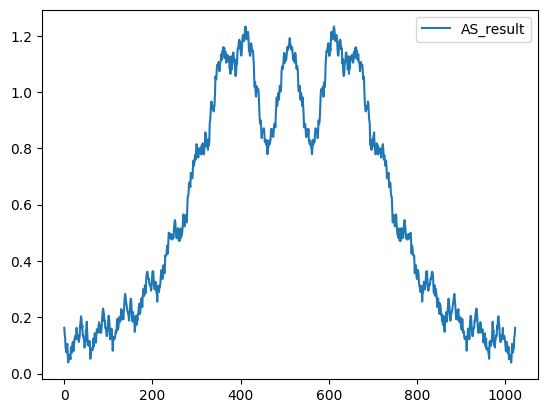

In [3]:
H_FR, g_z_AS = AS(1,50,-1)
plt.plot(g_z_AS, label="AS_result")

plt.legend()
plt.show()

## the implementation of numerical integration

In [4]:
from numba import njit


@njit(parallel=True)
def numerical_integration(wave_length=1, n_S=50):
    wave_length = wave_length  # the length of the wave
    dx = 2 * wave_length  # the sampling interval
    N = 1024  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    # real = np.zeros(1024)
    # imag = np.zeros(1024)
    inte_result = np.zeros(1024)

    N = 4000

    g_src = np.zeros(N)
    g_src[int(N / 4) : int(N / 4 * 3)] = np.ones(int(N / 2))

    y_real = np.zeros(N)
    y_imag = np.zeros(N)
    x = np.zeros(N)

    d_x = S / N
    for k in range(0, N):
        x[k] = d_x * k

    d_x_dest = 2 * wave_length

    for x_dest_n in range(0, 1024):
        for k in range(0, N):
            r = math.sqrt(z**2 + (x_dest_n * d_x_dest - x[k]) ** 2)
            exp = cmath.exp(2j * math.pi * r / wave_length)
            # print(x_dest_n * d_x_dest - x[k])
            # print(r)
            # print(exp)
            fx = (
                g_src[k]
                * (exp / r)
                * (z / r)
                * (1 / (2 * math.pi * r) + 1 / (1j * wave_length))
            )
            y_real[k] = fx.real
            y_imag[k] = fx.imag
        inte_result[x_dest_n] = abs(np.sum(y_real * d_x) + np.sum(1j * y_imag * d_x))
        # inte_result[x_dest_n] = abs(
        #     np.sum(np.multiply(fx, dx))
        # )
        # real[x_dest_n]=0.5*d_x*(2*np.sum(y_real)-y_real[0]-y_real[-1])
        # imag[x_dest_n]=0.5*d_x*(2*np.sum(y_imag)-y_imag[0]-y_imag[-1])

        inte_result_g = inte_result

    return inte_result_g

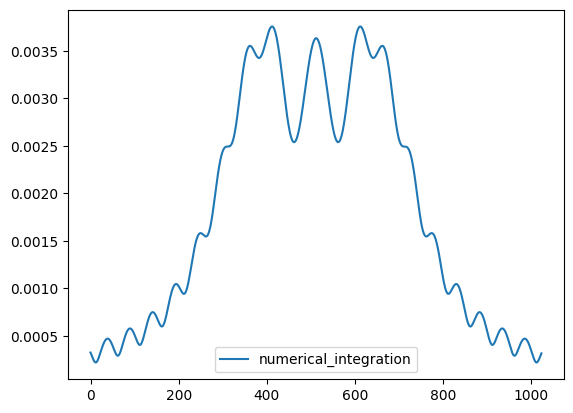

In [5]:
g_z = numerical_integration(1,50)
plt.plot(g_z, label="numerical_integration")

plt.legend()
plt.show()

## the AS evaluator

In [6]:
def AS_evaluator(wave_length=1, n_S=50):
    wave_length = wave_length  # the length Fof the wave
    dx = 2 * wave_length  # the sampling interval
    N = 1024 * 1024   #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    freq = np.fft.fftfreq(N, dx)
    freq_square = freq**2
    freq_squre_max = np.full(N, 1 / wave_length) ** 2
    w_square_0 = freq_squre_max - freq_square
    mask = w_square_0 > 0
    w_square = np.where(mask, w_square_0, 0)

    # the transfer function
    H_FR = np.empty(N, dtype=complex)
    H_FR = np.exp(2j * math.pi * z * np.sqrt(w_square))
    # H_FR = np.exp(1j * math.pi * z * (2 / wave_length - wave_length * (freq_square)))

    # generate the source plain spectrum
    g_0 = np.zeros(N)
    g_0[int(N / 2) - 256 : int(N / 2) + 256] = np.ones(int(512))

    G_0 = np.fft.fft(g_0)

    # the dest plain spectrum
    G_z = G_0 * H_FR

    # the dest plain
    g_z = abs(np.fft.ifft(G_z))

    return g_z[int(N / 2) - 512 : int(N / 2) + 512]

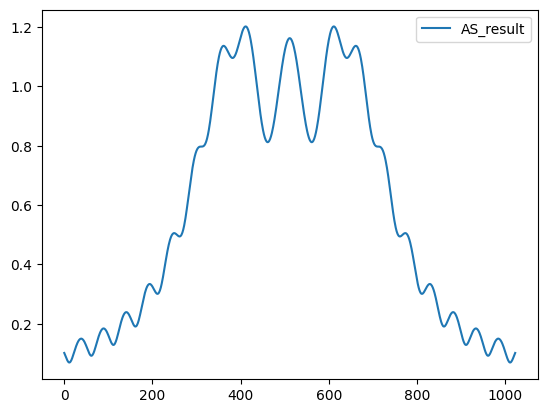

In [7]:
g_z_AS_evaluator = AS_evaluator(1,50)
plt.plot(g_z_AS_evaluator, label="AS_result")

plt.legend()
plt.show()

## the SNR of AS method with different propagation distances

In [8]:
def SNR_cal(signal, noisy_signal):
    # signal_power = np.mean(np.square(signal))
    # noise_power = np.mean(np.square(noisy_signal - signal))
    signal_power = np.mean(np.square(signal))
    noise_power = abs(np.mean(np.square(noisy_signal)) - np.mean(np.square(signal)))
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

In [9]:
SNR = []

n_S_list = list(np.linspace(-1, 2, 100))

for n_S in n_S_list:
    n_S = 10**n_S
    AS_spectrum, AS_result = AS(1, n_S, -1)
    SNR.append(SNR_cal(AS_evaluator(1, n_S), AS_result))

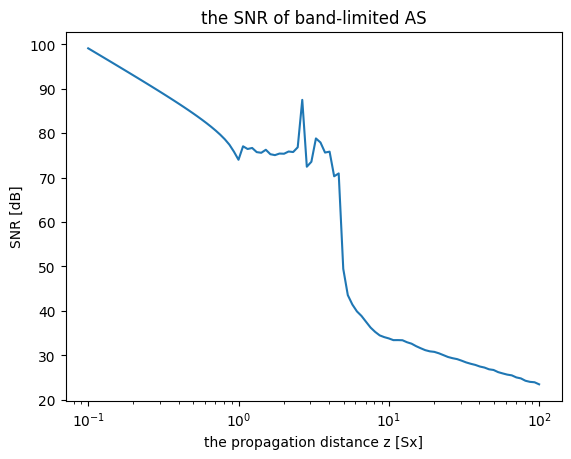

In [10]:
x = 10 ** np.array(n_S_list)
plt.plot(x, SNR)

plt.title("the SNR of band-limited AS")
plt.xlabel("the propagation distance z [Sx]")
plt.ylabel("SNR [dB]")

plt.xscale("log")
plt.show()

## improve the SNR by limiting the bandwidth

### implement of band_limited_AS

In [11]:
def band_limited_AS(wave_length, n_S):
    wave_length = wave_length  # the length Fof the wave
    dx = 2 * wave_length  # the sampling interval
    N = 2048  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    freq = np.fft.fftfreq(N, dx)
    freq = np.fft.fftshift(freq)

    d_u = 1 / (2 * S)
    u_limit = 1 / (np.sqrt((2 * d_u * z) ** 2 + 1) * wave_length)

    mask = abs(freq) <= (u_limit)
    if np.all(mask):
        clipper_n = -1
        max_frequency_retained = abs(freq[0])
    else:
        first_true_index = np.argmax(mask)
        clipper_n = N // 2 + 1 - first_true_index
        max_frequency_retained = abs(freq[first_true_index])

    H_FR_real, g_z = AS(1, n_S, clipper_n)

    print(
        f"under cut-off frequency {(u_limit)} : set clipper_n to be {clipper_n} (the max frequency retained : {max_frequency_retained})"
    )

    return max_frequency_retained, g_z

under cut-off frequency 0.01999600119960014 : set clipper_n to be 82 (the max frequency retained : 0.019775390625)
46.43677700406104


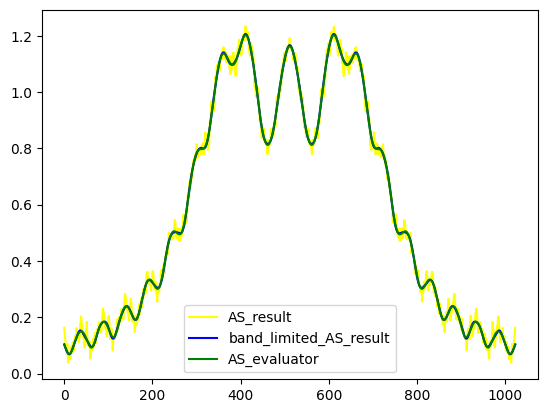

In [12]:
band_limited_AS_spectrum, band_limited_AS_result = band_limited_AS(1, 50)
AS_spectrum, AS_result = AS(1, 50, -1)

SNR_band_limited_AS_spectrum = SNR_cal(AS_evaluator(1, 50), band_limited_AS_result)
print(SNR_band_limited_AS_spectrum)

plt.plot(AS_result, label="AS_result",color='yellow')
plt.plot(band_limited_AS_result, label="band_limited_AS_result",color='blue')
plt.plot(AS_evaluator(1,50), label="AS_evaluator",color='green')

plt.legend()
plt.show()

### SNR of band-limited AS with different propagation distance

In [13]:
SNR_band_limited = []

n_S_list = list(np.linspace(-1, 2, 100))

for n_S in n_S_list:
    n_S = 10**n_S
    band_limited_AS_spectrum, band_limited_AS_result = band_limited_AS(1, n_S)
    AS_spectrum, AS_result = AS(1, n_S, -1)

    numerical_result = numerical_integration(1, n_S)
    SNR_band_limited.append(SNR_cal(AS_evaluator(1, n_S), band_limited_AS_result))

under cut-off frequency 0.9950371902099893 : set clipper_n to be -1 (the max frequency retained : 0.25)
under cut-off frequency 0.9943003175733328 : set clipper_n to be -1 (the max frequency retained : 0.25)
under cut-off frequency 0.993455112909366 : set clipper_n to be -1 (the max frequency retained : 0.25)
under cut-off frequency 0.9924859915972368 : set clipper_n to be -1 (the max frequency retained : 0.25)
under cut-off frequency 0.9913752349691566 : set clipper_n to be -1 (the max frequency retained : 0.25)
under cut-off frequency 0.9901027321227495 : set clipper_n to be -1 (the max frequency retained : 0.25)
under cut-off frequency 0.9886457013651091 : set clipper_n to be -1 (the max frequency retained : 0.25)
under cut-off frequency 0.9869783934070472 : set clipper_n to be -1 (the max frequency retained : 0.25)
under cut-off frequency 0.9850717800622875 : set clipper_n to be -1 (the max frequency retained : 0.25)
under cut-off frequency 0.9828932343539792 : set clipper_n to be 

the print output above shows different clipper_n regarding to different distance z

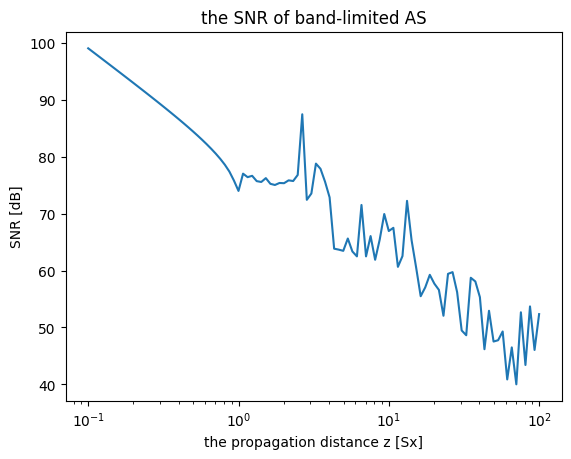

In [14]:
x = 10 ** np.array(n_S_list)
plt.plot(x, SNR_band_limited)

plt.title("the SNR of band-limited AS")
plt.xlabel("the propagation distance z [Sx]")
plt.ylabel("SNR [dB]")

plt.xscale("log")

plt.show()

### the improvement from SNR_band_limited compared to the original AS

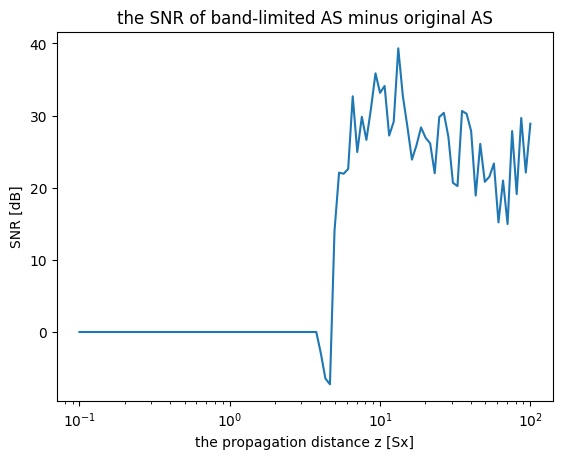

In [15]:
x = 10 ** np.array(n_S_list)
plt.plot(x, np.array(SNR_band_limited) - np.array(SNR))

plt.title("the SNR of band-limited AS minus original AS")
plt.xlabel("the propagation distance z [Sx]")
plt.ylabel("SNR [dB]")

plt.xscale("log")

plt.show()

### the clipper's effect on SNR

In [16]:
SNR_clipper = []

n_Sx = 50

n_clipper_list = list(np.linspace(1, 400, 400))
numerical_result = numerical_integration(1, n_Sx)
AS_spectrum, AS_result = AS(1, n_Sx, -1)
evaluator = AS_evaluator(1, n_Sx)

for n_clipper in n_clipper_list:
    band_limited_AS_spectrum, band_limited_AS_result = AS(1, n_Sx, int(n_clipper))
    SNR_clipper.append(SNR_cal(evaluator, band_limited_AS_result))

under cut-off frequency 0.01999600119960014 : set clipper_n to be 82 (the max frequency retained : 0.019775390625)
bandwidth needed: 0.029996625569424482
bandwidth of band-limited AS: 0.03955078125


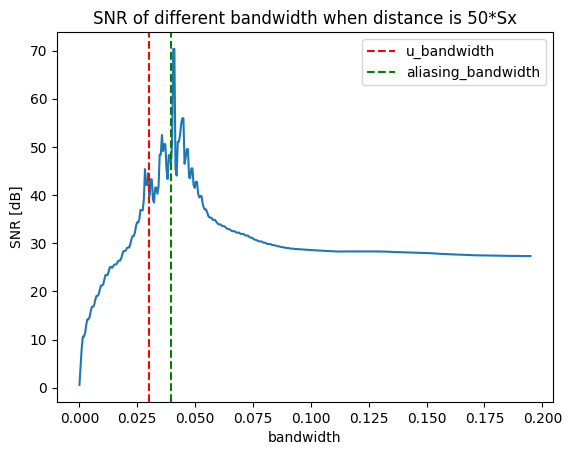

In [17]:
wave_length = 1  # the length of the wave
dx = 2 * wave_length  # the sampling interval
N = 2048  #  the number of samplings
S = 2048 * wave_length  # the size of the sampling window
z = n_Sx * S  # the propagation distance

freq = np.fft.fftfreq(N, dx)

max_frequency_retained, g_z = band_limited_AS(wave_length, n_Sx)
u_freq = 1 / math.sqrt((2 * z / (1.5 * S)) ** 2 + 1) / wave_length
u_bandwidth = 2*u_freq
aliasing_bandwidth = 2 * max_frequency_retained

print(f"bandwidth needed: {u_bandwidth}")
print(f"bandwidth of band-limited AS: {aliasing_bandwidth}")


plt.plot(2 * freq[0:400], SNR_clipper)

plt.axvline(x=u_bandwidth, color="r", linestyle="--", label="u_bandwidth")
plt.axvline(x=aliasing_bandwidth, color="g", linestyle="--", label="aliasing_bandwidth")


plt.title(f"SNR of different bandwidth when distance is {n_Sx}*Sx")

plt.xlabel("bandwidth")
plt.ylabel("SNR [dB]")

plt.legend()
plt.show()

## modified band-limited AS (add the minimum frequency condition)

In [18]:
def band_limited_AS_modified(wave_length, n_S):
    wave_length = wave_length  # the length Fof the wave
    dx = 2 * wave_length  # the sampling interval
    N = 2048  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    freq_unshift = np.fft.fftfreq(N, dx)
    freq = np.fft.fftshift(freq_unshift)

    d_u = 1 / (2 * S)
    u_limit = 1 / (np.sqrt((2 * d_u * z) ** 2 + 1) * wave_length)
    u_freq_extend = 1 / math.sqrt((2 * z / (1.5 * S)) ** 2 + 1) / wave_length

    cut_off_freq = max(u_limit, u_freq_extend)
    
    mask = abs(freq) <= (cut_off_freq)
    if np.all(mask):
        clipper_n = -1
        max_frequency_retained = abs(freq[0])
    else:
        first_true_index = np.argmax(mask)
        clipper_n = N // 2 + 1 - first_true_index
        max_frequency_retained = abs(freq[first_true_index])

    H_FR_real, g_z = AS(1, n_S, clipper_n)

    print(
        f"under cut-off frequency {(cut_off_freq)} : set clipper_n to be {clipper_n} (the max frequency retained : {max_frequency_retained})"
    )

    return max_frequency_retained, g_z